# Imports

In [120]:
#import camb
#pars = camb.CAMBparams()
from scipy.special import jn, jn_zeros
#from camb import model, initialpower
from scipy.interpolate import interp1d
from hankel_transform import *
from colossus.cosmology import cosmology
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

# Make sure this is consistent with the Colussus one ...
from astropy.cosmology import Planck15, Planck13, FlatLambdaCDM

# What value of H0?
# Does not use "h=1" units. Here h=0.67
print(Planck15.H(0))

import astropy.units as u
#rc('text', usetex=False)

67.73999999999998 km / (Mpc s)


In [121]:
# Here, cosmo will have h=1 units
#cosmo=FlatLambdaCDM(H0=100.0,Om0=0.3)#we want h=1 for some comparisons
cosmo = Planck15.clone(H0=100.0, Om0=0.3)
print(cosmo.H(0))

99.99999999999999 km / (Mpc s)


# Setting up the parameters for lensing and lens sample

In [122]:
zlens=0.2      # mean lens (foreground) redshift
zlens_min=0.1  # lower z cut on lens sample 
zlens_max=0.3  # upper z cut on lens sample

zsource=0.8   # source (background) redshift

# Shape noise
sigma_e=.36

# shape noise with responsivity factor
sigma_gamma=sigma_e/1.7

# number of background galaxies in units of N/arcmin^2
ns_angular = 18

# ******** Convert this to a number of background galaxies in units
# of N/(Mpc/h)^2 assuming the redshift of the lens sample
# use standard python packages to do this, astropy
n_s=8  # compute this here ...

# Sigma_crit
# critical surface mass density
# h inverse with 1+z factors comoving
# *****compute this here directly from the parameters above
# BEWARE: of h units and (1+z) factors
# Here we want the 1+z factors
# This can be computed by calling angular diameter distances
# We want the units here to be Msun/pc^2 (same units as delta sigma)
sigma_crit=4.7e3

shape_noise=sigma_crit**2*sigma_gamma**2/n_s#*cosmo.H_z(z=0.27)/cosmo.c

# b of lens sample
# **** Get the bias value of the DESI BGS sample 
# need to get this from the simulations
blens=1.33636828

# Space density of the lens sample
# ***** Get this from simulations
#n_g=3.e-4
n_g=0.00074634375
g_shot_noise=1./n_g

# *** Instead of hard coding, get the mean density here
# this is the mean density at redshift zero
# you can use the astropy package
# check that the results make sense

rho=0.04180594698596614 #units of Msun/pc^2/mpc, using h=1


In [123]:
from astropy import constants as const

In [124]:
cosmo.Om(zlens)

0.42529790838577969

In [125]:
const.G

<Constant name='Gravitational constant' value=6.67384e-11 uncertainty=8e-15 unit='m3 / (kg s2)' reference='CODATA 2010'>

In [126]:
cosmo2=FlatLambdaCDM(H0=70.0,Om0=0.3)#we want h=1 for some comparisons
print(cosmo.angular_diameter_distance(0.2))
print(cosmo2.angular_diameter_distance(0.2))

476.3727051749272 Mpc
680.5904857403505 Mpc


In [127]:
476*10/7

680.0

In [128]:
def sigma_crit(cosmo, zl, zs):
    constant_term = const.c*const.c/(4*np.pi*const.G)
    dist_term = cosmo.angular_diameter_distance(zs)/(cosmo.angular_diameter_distance_z1z2(zl,zs)*\
                                                     cosmo.angular_diameter_distance(zl))
    
    return (constant_term*dist_term*(1.0/(1+zl))**2).to(u.Msun/(u.pc*u.pc))
    #return (constant_term*dist_term).to(u.Msun/(u.pc*u.pc)).value

In [129]:
my_val = sigma_crit(cosmo, zlens, zsource)
print(my_val)

3428.0957407962496 solMass / pc2


In [130]:
print(my_val, my_val*((1.0+zlens)**2))

3428.0957407962496 solMass / pc2 4936.457866746599 solMass / pc2


In [131]:
my_val_inv = 1.0/my_val
my_val2 = 1.0/(my_val_inv)*(1.0+zlens)**2
print(my_val2)

4936.457866746599 solMass / pc2


In [132]:
alexie_val = 3419.65

In [133]:
(alexie_val/my_val.value)

0.997536317117477

In [134]:
(1/(1+zlens))**2

0.6944444444444445

In [135]:
print(cosmo.critical_density0)
print(cosmo.critical_density0.to(u.Msun/(u.pc*u.pc*u.Mpc)) )

1.8784710832284688e-29 g / cm3
0.27745945717500303 solMass / (Mpc pc2)


In [136]:
# Overlap area between DESI and HSC area in deg^2
area=1400

# Area in comoving units
area_comoving=area*(np.pi/180)**2*cosmo.comoving_distance(z=zlens)**2

# ********
# instead of hard coding, 
# compute this from zlens_min and zlens_max
# This is the comoving distance between zlens_min and zlens_max
# line of sight window lenght
# redshift bins lens Mpc
L_W=500

vol=area_comoving*L_W
vol=vol.value

# Get power spectrum

In [137]:
# Set up a new set of parameters for CAMB
# Here this is getting the non-linear matter power spectrum
kmax=30
kmin=.8e-3
k_smooth=1

# Note: CAMB automaticaly samples in log space
nk=5000
rmin=.6
rmax=110
non_linear=1

# We will test the differences between linear and non linear together with Sukhdeep

#pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
#pars.set_cosmology(H0=67.27, ombh2=0.022250, omch2=0.119800, mnu=0.06, omk=0, tau=0.06)
#pars.InitPower.set_params(ns=0.965, r=0,As =2.14e-09)
#pars.set_for_lmax(2500, lens_potential_accuracy=0)

# This is the redshift of the lens sample
#zb=[.27]#
#pars.set_matter_power(redshifts=zb,kmax=kmax);
#if non_linear==1:
#    pars.NonLinear = model.NonLinear_both
#else:
#    pars.NonLinear = model.NonLinear_none
#results = camb.get_results(pars)
#kh, z, pk =results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints =nk)

# Use linear or non linear
# Use linear but then test with Sukhdeep

# what is zb here?
# => lens Redshift

In [138]:
# define a vector of cosmological parameters
# Make sure it is consistent with the one above

my_cosmo = {'flat': True, 'H0': 73.0, 'Om0': 0.238, 'Ob0': 0.045714, 'sigma8': 0.74, 'ns': 0.951}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

0.005999839999999999
5000


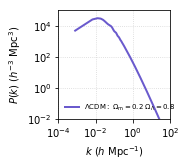

In [139]:
# input model spectrum for comparison
# lka = np.arange(-4.,3.,0.02)
#ka = 10.0**lka

# Do we want the sampling in log?
# Units of pk, make sure they are the same
# ask for the P(k) camb to see if it we get the same thing

# Sample in log space
# In parctice, the hankel transform does its own interpolation later down the line anyway and so 
# it shouldn't matter though
step=(kmax-kmin)/nk
print(step)

# Colosus assumed h/Mpc
kh = np.arange(kmin,kmax,step)
print(len(kh))

# What is the redshift here?
# probaly need to apply the growth function

# The wavenumber k (in comoving h/Mpc)
pk = cosmo.matterPowerSpectrum(kh, 'eh98')
cosmo.interpolation = True

# plot input model P(k) 

plt.figure(figsize=(2,2))
plt.xscale('log'); plt.yscale('log')
plt.ylim(1.e-2, 1.e5); plt.xlim(1.e-4, 1.e2)
plt.plot(kh, pk, c='slateblue', linewidth=2., label=r'$\Lambda\mathrm{CDM}:\ \Omega_{\rm m}=%.1f\ \Omega_\Lambda=%.1f$'%(cosmo.Om0,cosmo.OL0))
plt.legend(frameon=False, loc='lower left', fontsize=7, scatterpoints=1)
plt.xlabel(r'$k\ (h\rm\ Mpc^{-1})$')
plt.ylabel(r'$P(k)\ (h^{-3}\ \rm Mpc^3)$')
plt.grid(linestyle='dotted', c='lightgray')
plt.show()


In [140]:
#Setting up the Hankel Transform
#This deals with the interpolation over the Bessel Functions
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0],n_zeros=28000,kmin=kmin)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 0  not enough zeros to cover kmin, increasing by  1000  to 29000
CPU times: user 19.1 s, sys: 555 ms, total: 19.6 s
Wall time: 24.3 s


In [141]:
# Note to ourselves: get the h factors correct

# CAMB version
# the CAMB version computes at multipe redshifts
# The [0] here is just taking the first redshifts
#pk_taper=HT.taper(k=kh,pk=pk[0],large_k_lower=5,large_k_upper=kmax,low_k_lower=kmin,
#                     low_k_upper=kmin*2)

# This tapers to function at the edges to make it go to zero nicely
# To avoid runing when you take the fourier transform
pk_taper=HT.taper(k=kh,pk=pk,large_k_lower=5,large_k_upper=kmax,low_k_lower=kmin,
                     low_k_upper=kmin*2)


#need atleast k=10 and k=1.e-3 to get decent wgg for 1-100 Mpc/h range.
print(pk_taper)

[  3.09078052e-13   2.64912777e+04   3.17831188e+04 ...,   8.44329461e-06
   5.62580794e-06   2.81137739e-06]


# g-g Lensing covariance

We are using the real-space DS(r_p) covariance expression from Sukhdeep Singh's paper, Eq 10.
http://adsabs.harvard.edu/abs/2016arXiv161100752S

Here we are using the part withuot the curly brackets (as explained later in the text, if you subtract DS around randoms to get the optimal estimator, you get rid of the curly brackets term)

We are ignoring the connected $T_{g \gamma g \gamma}$ term, as it’s unlikely to be very important and is so much harder to calculate, and we are just keeping the $(P_{gg} + N_g) (P_{\gamma \gamma} + N_\gamma) + P_{g \gamma}^2$ stuff, so you have lens clustering and shot noise, cosmic shear and shape noise, and cosmic variance terms.

In [142]:
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[2],n_zeros=60000,kmin=kmin)

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 61000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 62000
CPU times: user 33 s, sys: 473 ms, total: 33.5 s
Wall time: 33.6 s


In [143]:
# cnvergence power spectrum
# approximation
# just integrating 
# Dchi2 is the integral over the window function
Dchi2=900 #integral over product of window functions units is Mpc?
p_kappa_kappa=pk*(rho)**2*Dchi2

In [144]:
p_g=blens**2*pk
p_gk=blens*pk*rho

In [145]:
r_bins=np.logspace(-1,np.log10(110),24)

In [146]:
taper_kw=dict({'large_k_lower':10,'large_k_upper':kmax,'low_k_lower':kmin,'low_k_upper':kmin*1.2})

In [147]:
# Pgg x Pgammagamma
r,cov_ggkk=HT.projected_covariance(k_pk=kh,pk1=p_g+g_shot_noise,pk2=p_kappa_kappa+shape_noise,j_nu=2,taper=True,**taper_kw)
r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/Users/kipac-slac-loaner/Git/desiDeltaSigma/hankel_transform.py:98: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [148]:
# g gamma ^2
r,cov_gkgk=HT.projected_covariance(k_pk=kh,pk1=p_gk,pk2=p_gk,
                               kmax=100,rmin=.8,j_nu=2,rmax=110,n_zeros=3500)#return_Jrr=True,Jrr=Jrr
cov_gkgk*=Dchi2
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

/Users/kipac-slac-loaner/Git/desiDeltaSigma/hankel_transform.py:98: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [149]:
cov_final=(cov_ggkk_re+cov_gkgk_re)/vol
corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)

/Users/kipac-slac-loaner/Git/desiDeltaSigma/hankel_transform.py:98: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


(0.6, 110)

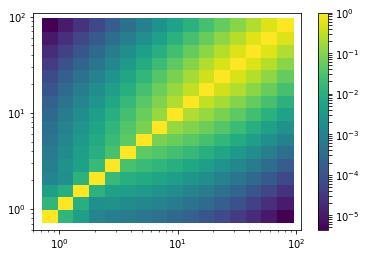

In [150]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
plt.pcolor(r_re,r_re,corr,norm=colors.LogNorm())
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlim(HT.rmin,HT.rmax)
plt.ylim(HT.rmin,HT.rmax)

(1, 100)

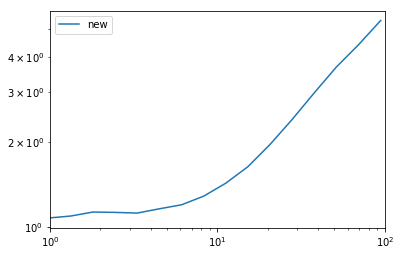

In [151]:
plt.plot(r_re,r_re*errors,label='new')
#plot(error_qpm['rp'],error_qpm['rp']*error_qpm['DS_err_gR'])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1,100)